# Intrinsic Dimension with VAE using Sparse projection

In [24]:
import os
import sys
import math
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.random_projection import SparseRandomProjection as SRP
from scipy.sparse import find
from sklearn.preprocessing import normalize

sys.path.append(str(Path.cwd().parent))
from utils.train_val import train_net #, train_epoch, validate_epoch, save_checkpoint
from utils.train_val_vae import train_vae #, train_epoch, validate_epoch, save_checkpoint

from utils.data_loaders import mnist_loaders

# sys.path.append(str(Path.cwd().parent.parent))
# from pytorch_testing.tests.unit_tests import Tester, SimpleNet

%reload_ext autoreload
%autoreload 2
%matplotlib inline

DEVICE = torch.device("cuda:0")
PATH = '../data/'

In [22]:
class SparseVAE(nn.Module):
    ''' Optimize subspace of parameters of network defined as  using dense projection.
    
    d: intrinsic dimension size to test
    layers: torch.nn.ModuleDict()
    config: dict with same keys as layers, containing 3 objects: 
            'type' (str): type of layer
            'params' (dict) : all the params to specify the layer (type, ...)
            'activation' (dict) : if there is an activation after the layer
    
    ??? This still won't work for resnets, or any other more complex network
    '''
    
    def __init__(self, d, input_dim=1, output_dim=1, latent_size=8, img_size=28, DEVICE='cuda'):
        super(SparseVAE, self).__init__()
        self.d = d
        self.opt_basis = nn.Parameter(torch.zeros(self.d).to(DEVICE), requires_grad=True)
        
        self.latent_size = latent_size
        self.img_size = img_size
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.linear_size = int(16*(img_size/4)**2)
        
        self.layers = torch.nn.ModuleDict()

        self.layers['enc_conv1'] = nn.Conv2d(self.input_dim, 32, kernel_size=5, stride=1, padding=2, bias=False)
        self.layers['enc_bn1'] = nn.BatchNorm2d(32, track_running_stats=True)
        self.layers['enc_act1'] = nn.ELU()
        self.layers['enc_conv2'] = nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1, bias=False)
        self.layers['enc_bn2'] = nn.BatchNorm2d(32, track_running_stats=True)
        self.layers['enc_act2'] = nn.ELU()
        self.layers['enc_conv3'] = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.layers['enc_bn3'] = nn.BatchNorm2d(64, track_running_stats=True)
        self.layers['enc_act3'] = nn.ELU()
        self.layers['enc_conv4'] = nn.Conv2d(64, 16, kernel_size=5, stride=1, padding=2, bias=True)

        self.layers['dec_conv1'] = nn.ConvTranspose2d(16, 32, kernel_size=4, stride=1, padding=2,  output_padding=0, bias=False)
        self.layers['dec_bn1'] = nn.BatchNorm2d(32, track_running_stats=True)
        self.layers['dec_act1'] = nn.ELU()
        self.layers['dec_conv2'] = nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=1,  output_padding=1, bias=False)
        self.layers['dec_bn2'] = nn.BatchNorm2d(16, track_running_stats=True)
        self.layers['dec_act2'] = nn.ELU()
        self.layers['dec_conv3'] = nn.ConvTranspose2d(16, 16, kernel_size=5, stride=2, padding=2,  output_padding=1, bias=False)
        self.layers['dec_bn3'] = nn.BatchNorm2d(16, track_running_stats=True)
        self.layers['dec_act3'] = nn.ELU()
        self.layers['dec_conv4'] = nn.ConvTranspose2d(16, self.output_dim, kernel_size=3, stride=1, padding=1,  output_padding=0, bias=True)
        
        self.config = {}
        self.config['fc_mu_logvar'] = 'linear'
        self.config['fc_dec'] = 'linear'
        self.config['enc_conv1'] = 'conv2d'
        self.config['enc_bn1'] = 'batch_norm'
        self.config['enc_act1'] = 'elu'
        self.config['enc_conv2'] = 'conv2d'
        self.config['enc_bn2'] = 'batch_norm'
        self.config['enc_act2'] = 'elu'
        self.config['enc_conv3'] = 'conv2d'
        self.config['enc_bn3'] = 'batch_norm'
        self.config['enc_act3'] = 'elu'
        self.config['enc_conv4'] = 'conv2d'
        self.config['dec_conv1'] = 'conv_transpose2d'
        self.config['dec_bn1'] = 'batch_norm'
        self.config['dec_act1'] = 'elu'
        self.config['dec_conv2'] = 'conv_transpose2d'
        self.config['dec_bn2'] = 'batch_norm'
        self.config['dec_act2'] = 'elu'
        self.config['dec_conv3'] = 'conv_transpose2d'
        self.config['dec_bn3'] = 'batch_norm'
        self.config['dec_act3'] = 'elu'
        self.config['dec_conv4'] = 'conv_transpose2d'
        self.layers['fc_mu_logvar'] = nn.Linear(self.linear_size, 2*self.latent_size)
        self.layers['fc_dec'] = nn.Linear(self.latent_size, self.linear_size)
        
        # get full dimension
        self.D = 0
        for name, layer in self.layers.items():
            if hasattr(layer, 'weight'):
                self.D += torch.prod(torch.tensor(layer.weight.size()))
                if layer.bias is not None:
                    self.D += torch.prod(torch.tensor(layer.bias.size()))
                layer.requires_grad = False # none of the layers will be updated
            
        self.D = self.D.item()
        self.get_projection_matrix()
        
    def slice_sparse_tensor(self, sparse_t, idx, dim):
        # some from https://stackoverflow.com/questions/50666440/column-row-slicing-a-torch-sparse-tensor

        def compact1D(x):
            """ NORMALIZE indices to begin at 0 for new sliced tensor
            "Compact" values 1D uint tensor, so that all values are in [0, max(unique(x))].
            """
            x_sorted, x_sorted_ind = torch.sort(x, descending=True)
            x_sorted_unique, x_sorted_unique_ind = torch.unique(x_sorted, return_inverse=True)
            x[x_sorted_ind] = x_sorted_unique_ind
            return x

        idx = torch.tensor(idx)
        sparse_i = sparse_t._indices()
        sparse_v = sparse_t._values()

        # find indices that are in the sparse tensor
        # getting an error, so do it on cpu. CPU is too much memory, so do more efficient np method
        existing_idx = np.isin(sparse_i[dim].cpu().numpy(), idx.cpu().numpy())
        existing_idx = torch.from_numpy(existing_idx).byte().to(DEVICE)
        
        existing_idx = existing_idx.nonzero().squeeze()
        sparse_i = sparse_i.to(DEVICE)
        
        # keep only existing indices
        v_sliced = sparse_v[existing_idx]

        # grab the indices that we want to keep
        i_sliced = sparse_i.index_select(dim=1, index=existing_idx)

        # Building sparse result tensor:
        i_sliced[0] = compact1D(i_sliced[0])
        i_sliced[1] = compact1D(i_sliced[1])

        # find the new size
        size_sliced = torch.tensor(sparse_t.size())
        size_sliced[dim] = len(idx)
        size_sliced = (size_sliced[0], size_sliced[1]) 
        
        subset_sparse_t = torch.sparse.FloatTensor(i_sliced.to(DEVICE), v_sliced.to(DEVICE), size_sliced)
        return subset_sparse_t.to(DEVICE)
    
    def get_projection_matrix(self):
        M = SRP(self.d)._make_random_matrix(self.D, self.d)
        M = normalize(M, norm='l2', axis=0)
        fm=find(M)
        
        idx = torch.LongTensor(np.array([fm[0],fm[1]]))
        vals = torch.tensor(fm[2])
        proj_matrix = torch.sparse.FloatTensor(idx, vals, (self.D, self.d))
        
        # Turn it into a nice format for a weight and bias matrix for each layer
        p_idx = 0
        self.projection = {}
        for name, layer in self.layers.items():
            if hasattr(layer, 'weight'): # ignore anything that doesn't have params like act
                self.projection[name] = {}
                n_weights = torch.prod(torch.tensor(layer.weight.size()))
                self.projection[name]['weight'] = self.slice_sparse_tensor(proj_matrix, 
                                                                      idx=list(range(p_idx, p_idx + n_weights)), 
                                                                      dim=0).float()
                self.projection[name]['weight'].requires_grad = False
                # also make sure the layers aren't trainable
                self.layers[name].weight.requires_grad = False
                p_idx += n_weights
                if layer.bias is not None:
                    n_weights = torch.prod(torch.tensor(layer.bias.size()))
                    self.projection[name]['bias'] = self.slice_sparse_tensor(proj_matrix, 
                                                                      idx=list(range(p_idx, p_idx + n_weights)), 
                                                                      dim=0).float()
                    self.projection[name]['bias'].requires_grad = False
                    # also make sure the layers aren't trainable
                    self.layers[name].bias.requires_grad = False
                    p_idx += n_weights

    def get_layer_activation(self, name):
        mapping={'linear':F.linear,
                 'conv2d': F.conv2d,
                 'conv_transpose2d': F.conv_transpose2d,
                 'relu': F.relu,
                 'elu': F.elu,
                 'batch_norm': F.batch_norm
                }
        return mapping[name] if name is not None else None

    def encode(self, x):
        for name, nn_layer in self.layers.items():
            if name[0:3] == 'enc':
                params = vars(self.layers[name]) #self.config[name]['params'] vars(x)
                params = {k: v for k, v in params.items() if k in ['stride', 'padding', 'dilation', 'groups',
                                                                    'running_mean', 'running_var']}
                layer = self.get_layer_activation(self.config[name])

                if self.config[name] in ['linear', 'conv2d', 'conv_transpose2d', 'batch_norm']:
                    new_weight = self.layers[name].weight + torch.sparse.mm(self.projection[name]['weight'], 
                                                                            self.opt_basis.unsqueeze(-1)
                                                               ).view(self.layers[name].weight.size())
                    params['weight'] = new_weight

                    if self.layers[name].bias is not None:
                        new_bias = self.layers[name].bias + torch.sparse.mm(self.projection[name]['bias'], 
                                                                            self.opt_basis.unsqueeze(-1)
                                                                   ).view(self.layers[name].bias.size())
                        params['bias'] = new_bias

                else: # this is an activation, so no params
                    pass
                
                if self.config[name] is 'batch_norm':
                    nn_layer.weight = nn.Parameter(params['weight'])
                    nn_layer.bias = nn.Parameter(params['bias'])
                    x = nn_layer(input=x)
                else:
                    x = layer(input=x, **params)
               
        # final FC layer
        x = x.view(x.size(0), -1)
        params = vars(self.layers['fc_mu_logvar']) #self.config[name]['params'] vars(x)
        params = {k: v for k, v in params.items() if k in ['stride', 'padding', 'dilation', 'groups',
                                                                'running_mean', 'running_var']}
        layer = self.get_layer_activation(self.config['fc_mu_logvar'])
        new_weight = self.layers['fc_mu_logvar'].weight + torch.sparse.mm(self.projection['fc_mu_logvar']['weight'], 
                                                                self.opt_basis.unsqueeze(-1)
                                                   ).view(self.layers['fc_mu_logvar'].weight.size())
        new_bias = self.layers['fc_mu_logvar'].bias + torch.sparse.mm(self.projection['fc_mu_logvar']['bias'], 
                                                            self.opt_basis.unsqueeze(-1)
                                                   ).view(self.layers['fc_mu_logvar'].bias.size())
        
        params['weight'] = new_weight
        params['bias'] = new_bias
        mu_logvar = layer(input=x, **params) 
        return mu_logvar


    def decode(self, x):
        params = vars(self.layers['fc_dec']) #self.config[name]['params'] vars(x)
        params = {k: v for k, v in params.items() if k in ['stride', 'padding', 'dilation', 'groups',
                                                              'running_mean', 'running_var', 'output_padding']}
        layer = self.get_layer_activation(self.config['fc_dec'])
        new_weight = self.layers['fc_dec'].weight + torch.sparse.mm(self.projection['fc_dec']['weight'], 
                                                                self.opt_basis.unsqueeze(-1)
                                                   ).view(self.layers['fc_dec'].weight.size())
        new_bias = self.layers['fc_dec'].bias + torch.sparse.mm(self.projection['fc_dec']['bias'], 
                                                            self.opt_basis.unsqueeze(-1)
                                                   ).view(self.layers['fc_dec'].bias.size())
        params['weight'] = new_weight
        params['bias'] = new_bias
        x = layer(input=x, **params)
        x = x.view((-1, 16, int(self.img_size/4), int(self.img_size/4)))

        for name, nn_layer in self.layers.items():
            if name[0:3] == 'dec':
                params = vars(self.layers[name]) #self.config[name]['params'] vars(x)
                params = {k: v for k, v in params.items() if k in ['stride', 'padding', 'dilation', 'groups',
                                                                     'running_mean', 'running_var', 'output_padding']}
                layer = self.get_layer_activation(self.config[name])

                if self.config[name] in ['linear', 'conv2d', 'conv_transpose2d', 'batch_norm']:
                    new_weight = self.layers[name].weight + torch.sparse.mm(self.projection[name]['weight'], 
                                                                            self.opt_basis.unsqueeze(-1)
                                                               ).view(self.layers[name].weight.size())
                    params['weight'] = new_weight
                    if self.layers[name].bias is not None:
                        new_bias = self.layers[name].bias + torch.sparse.mm(self.projection[name]['bias'], 
                                                                            self.opt_basis.unsqueeze(-1)
                                                                   ).view(self.layers[name].bias.size())
                        params['bias'] = new_bias
                else: # this is an activation, so no params
                    pass
                if self.config[name] is 'batch_norm':
                    nn_layer.weight = nn.Parameter(params['weight'])
                    nn_layer.bias = nn.Parameter(params['bias'])
                    x = nn_layer(input=x)
                else:
                    x = layer(input=x, **params)
        return torch.sigmoid(x)

    def reparameterize(self, mu_logvar, deterministic=False):
        mu = mu_logvar[:, 0:int(mu_logvar.size()[1]/2)]
        if deterministic: # return mu 
            return mu
        else: # return mu + random
            logvar = mu_logvar[:, int(mu_logvar.size()[1]/2):]
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        
    def forward(self, x, deterministic=False):
        mu_logvar = self.encode(x)
        z = self.reparameterize(mu_logvar, deterministic)
        recon_x = self.decode(z)
        return recon_x, mu_logvar

In [64]:
train_loader, val_loader = mnist_loaders(PATH, bs=256)
model = SparseVAE(d=8192).to(DEVICE)
metrics = train_vae(model, train_loader, val_loader, epochs=3, verbose=1, device=DEVICE)
print('Best Loss:', metrics['val']['best_loss'])










  0%|          | 0/3 [00:00<?, ?it/s]








 33%|███▎      | 1/3 [03:20<06:41, 200.85s/it]








 67%|██████▋   | 2/3 [06:42<03:20, 201.00s/it]








100%|██████████| 3/3 [10:02<00:00, 200.94s/it]










Best Loss: 619.6574358398437


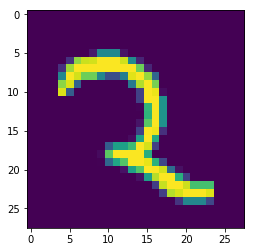

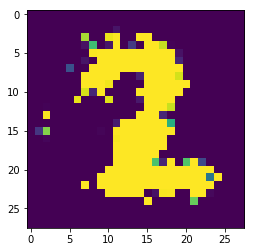

In [65]:
x, y = next(iter(train_loader))
x = x.to(DEVICE)
x_recon, mu_logvar = model(x)

plt.imshow(x[1, :, :, :].squeeze().cpu().detach().numpy())
plt.show()
plt.imshow(x_recon[1, :, :, :].squeeze().cpu().detach().numpy())
plt.show()

In [68]:
train_loader, val_loader = mnist_loaders(PATH, bs=256)
model = SparseVAE(d=8192).to(DEVICE)
metrics = train_vae(model, train_loader, val_loader, epochs=6, verbose=1, device=DEVICE)
print('Best Loss:', metrics['val']['best_loss'])










  0%|          | 0/6 [00:00<?, ?it/s]








 17%|█▋        | 1/6 [03:22<16:51, 202.40s/it]








 33%|███▎      | 2/6 [06:44<13:29, 202.44s/it]








 50%|█████     | 3/6 [10:07<10:07, 202.46s/it]








 67%|██████▋   | 4/6 [13:30<06:44, 202.49s/it]








 83%|████████▎ | 5/6 [16:52<03:22, 202.51s/it]








100%|██████████| 6/6 [20:15<00:00, 202.53s/it]










Best Loss: 566.2166041992188


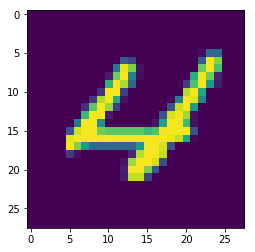

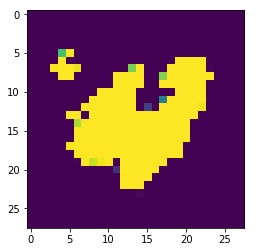

In [69]:
x, y = next(iter(train_loader))
x = x.to(DEVICE)
x_recon, mu_logvar = model(x)

plt.imshow(x[1, :, :, :].squeeze().cpu().detach().numpy())
plt.show()
plt.imshow(x_recon[1, :, :, :].squeeze().cpu().detach().numpy())
plt.show()

In [70]:
train_loader, val_loader = mnist_loaders(PATH, bs=256)
model = SparseVAE(d=8192).to(DEVICE)
metrics = train_vae(model, train_loader, val_loader, epochs=13, verbose=1, device=DEVICE)
print('Best Loss:', metrics['val']['best_loss'])

x, y = next(iter(train_loader))
x = x.to(DEVICE)
x_recon, mu_logvar = model(x)

plt.imshow(x[1, :, :, :].squeeze().cpu().detach().numpy())
plt.show()
plt.imshow(x_recon[1, :, :, :].squeeze().cpu().detach().numpy())
plt.show()










  0%|          | 0/13 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/home/rene/miniconda3/envs/HVAE/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/rene/miniconda3/envs/HVAE/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/rene/miniconda3/envs/HVAE/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/rene/miniconda3/envs/HVAE/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/rene/miniconda3/envs/HVAE/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/rene/miniconda3/envs/HVAE/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/ho

KeyboardInterrupt: 